# Grad-CAM可解释性分析

## 导入工具包

In [61]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.models import resnet50

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入ImageNet预训练图像分类模型

In [62]:
model = resnet50(pretrained=True).eval().to(device)

## 图像预处理

In [63]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(512),
                                     # transforms.CenterCrop(512),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 载入测试图像

In [64]:
img_path = 'test_img/cat_dog.jpg'

In [82]:
img_pil = Image.open(img_path)

In [83]:
# img_pil

In [65]:
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理

In [66]:
input_tensor.shape

torch.Size([1, 3, 512, 768])

input_tensor 可以在 batch 维度有多张图片

## 指定分析的类别

In [67]:
# 如果 targets 为 None，则默认为最高置信度类别
targets = [ClassifierOutputTarget(232)]

281 虎斑猫

232 边牧犬

## 分析模型结构，确定待分析的层

In [68]:
# model

In [69]:
model.layer4[-1]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

In [70]:
model.layer1[0]

Bottleneck(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

## 选择可解释性分析方法（任选一个）

In [71]:
from pytorch_grad_cam import GradCAM, HiResCAM, GradCAMElementWise, GradCAMPlusPlus, XGradCAM, AblationCAM, ScoreCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad


In [72]:
# Grad-CAM
from pytorch_grad_cam import GradCAM
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [73]:
# # Grad-CAM++
# from pytorch_grad_cam import GradCAMPlusPlus
# target_layers = [model.layer4[-1]]
# cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)

## 生成CAM热力图

In [74]:
cam_map = cam(input_tensor=input_tensor, targets=targets)[0] # 不加平滑
# cam_map = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)[0] # 加平滑

In [75]:
# 也可以这么写
# with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
#     cam_map = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)[0]

## 可视化CAM热力图

In [76]:
cam_map.shape

(512, 768)

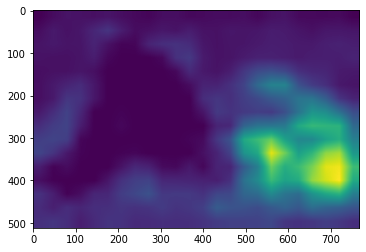

In [77]:
plt.imshow(cam_map)
plt.show()

In [78]:
import torchcam
from torchcam.utils import overlay_mask

result = overlay_mask(img_pil, Image.fromarray(cam_map), alpha=0.6) # alpha越小，原图越淡

In [81]:
# result

In [80]:
result.save('output/B1.jpg')